# Setup

In [ ]:
#@title Imports
import pandas as pd
from matplotlib import pyplot as plt
import json
import random
import openai
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
import numpy as np
import seaborn as sns

In [ ]:
#@title Mount drive (used for reading and writing files, do not run)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title load sample (The initial profiles sample for Active Learning)
sample_path = 'sample_point.csv'
sample_df = pd.read_csv(sample_path)

# procedure for getting data from Databricks. unnecessary.
# string_cols = ('about','position')
# special_char = '§'

# def replace_func(x):
#     if type(x) == str:
#         return x.replace(special_char, ',')


# for col in string_cols:
#     sample_df[col] = sample_df[col].apply(replace_func)

In [ ]:
#@title Encode pair as string function
def user_to_string(user_series, user_type):
    """Represent the user with a string. Used for quering LLM"""
    string = 'The ' + user_type + ' said about themself: "' + user_series['about'] + '".\n'

    user_education = user_series['education']
    if type(user_series['education']) == str:
      user_education = json.loads(user_series['education'])
    while {} in user_education:
        user_education.remove({})
    if len(user_education) > 0:
        string += 'The ' + user_type + ' has the following educations: \n'

        for education in user_education:
            if 'degree' in education:
                if 'field' in education:
                    string += education['degree'] + ' in ' + education['field'] + '\n'
                else:
                    string += education['degree'] + '\n'
            elif 'title' in education:
                string += education['title'] + '\n'
            else:
              print(f'bad education: {education}')

    user_experience = user_series['experience']
    if type(user_series['experience']) == str:
      user_experience = json.loads(user_series['experience'])
    if len(user_experience) > 0:
        string += 'The ' + user_type + ' has the following experience titles: '
        for experience in user_experience:
            if 'title' in experience:
                string += experience['title'] + ', '
            else:
                for position in experience['positions']:
                    string += position['title'] + ', '
        string = string[:-1] + '.\n'

    string += 'The number of followers the ' + user_type + ' has is: ' + str(user_series['followers']) + '\n'

    return string

def pair_to_query(mentor_series, mentee_series):
    """The labeling query given to the LLM"""
    mentor_str = user_to_string(mentor_series, 'mentor')
    mentee_str = user_to_string(mentee_series, 'mentee')

    query = 'Information is given about a potential mentor mentee pair. Label it as Good or Bad.\n' + mentor_str + mentee_str
    query += 'Is the mentor mentee pair a good match?\n'
    query += 'Label: '
    return query

In [ ]:
#@title load labels
# GPT labels dataset
labels_path = "ytb_labels.csv"
labels_df = pd.read_csv(labels_path)

# Cohere labels dataset
cohere_labels_path = 'ytb_cohere_labels.csv'
cohere_labels_df = pd.read_csv(cohere_labels_path)
print(len(labels_df), len(cohere_labels_df))

35661 986


In [ ]:
#@title Query GPT-4o-mini setup
client = openai.OpenAI(
  api_key=input()
)

def query_gpt(query):
  completion = client.chat.completions.create(
    model="gpt-4o-mini",
    store=False,
    messages=[
      {"role": "user", "content": query}
    ]
  )
  return completion.choices[0].message.content

In [ ]:
#@title Query Cohere setup
cohere_key = input()
cohere_model = cohere.ClientV2(api_key=cohere_key)

def query_cohere(query):
    res = cohere_model.chat(
    model="command-r-plus-08-2024",
    messages=[
        {
            "role": "user",
            "content":query,
        }
    ])
    return res.message.content[0].text

# Initial labeling for Active Learning

In [ ]:
#@title labeling function
def label_pair(mentor_series, mentee_series, labeler, labeled_df):
  mentor_id = mentor_series['id']
  mentee_id = mentee_series['id']

  # only label unlabeled pairs
  pair_exists = not labeled_df[(labeled_df["mentor_id"] == mentor_id) & (labeled_df["mentee_id"] == mentee_id)].empty
  if pair_exists:
    return

  query = pair_to_query(mentor_series, mentee_series)
  label = labeler(query)
  if label == "Good":
    label = 1
  elif label == "Bad":
    label = 0
  else:
    return

  # add the label to the dataset
  labeled_df.loc[len(labeled_df)] = [mentor_id, mentee_id, label]

In [ ]:
#@title Label random 20000 pairs
for i in range(2000):
  print(f'num: {10*i}/2000')
  for j in range(10):
    pair = sample_df.sample(2)
    try:
      label_pair(pair.iloc[0], pair.iloc[1], query_gpt, labels_df)
    except:
      continue
  labels_df.to_csv(labels_path, index=False)

# Label Predictions

In [ ]:
#@title Load model predictions function
def load_predictions(path):
  predictions_df = pd.read_csv(path)
  wanted_cols = ['mentor', 'mentee', 'prediction']
  predictions_df['mentor'] = predictions_df['id'].apply(lambda x: x.split('_')[0])
  predictions_df['mentee'] = predictions_df['id'].apply(lambda x: x.split('_')[1])
  if 'probability' in predictions_df.columns:
    predictions_df['prob'] = predictions_df['probability'].apply(lambda x: json.loads(x)['values'][1])
    wanted_cols.append('prob')
  predictions_df = predictions_df[wanted_cols]
  return predictions_df

In [ ]:
#@title Load predictions
logistic1_df = load_predictions('logistic1.csv')

In [ ]:
#@title Select worst confidence (Run for Active Learning)
logistic1_df['dist_half'] = logistic1_df['prob'].apply(lambda x: abs(x - 0.5))
logistic1_df = logistic1_df.sort_values(by='dist_half', ascending=True)
logistic1_df = logistic1_df.head(3000).drop('dist_half', axis=1)

In [ ]:
#@title Save the user ids in the predictions (For communication with Databricks)
processed_pred_path = 'ytb_processed_predictions2_users.csv'
unique_users_df = pd.concat((logistic1_df['mentor'], logistic1_df['mentee'])).unique()
pd.DataFrame(unique_users_df, columns=['id']).to_csv(processed_pred_path, index=False)

In [ ]:
#@title Load a subset of profiles, that has all profiles appearing in the predictions
full_users_path = 'full_users_for_prediction1.csv'
users_for_pred = pd.read_csv(full_users_path)

In [ ]:
#@title Label all predictions
count=0
for i, row in logistic1_df.iterrows():
  count+=1
  print(f'{count}/{len(logistic1_df)}')
  mentor_id = row['mentor']
  mentee_id = row['mentee']
  full_mentor = users_for_pred[users_for_pred['id'] == mentor_id].iloc[0]
  full_mentee = users_for_pred[users_for_pred['id'] == mentee_id].iloc[0]
  try:
    label_pair(full_mentor, full_mentee, query_gpt, labels_df)
    labels_df.to_csv(labels_path, index=False)
  except Exception as e:
    print(e)
    continue

# Plot results

In [ ]:
#@title Load predictions function
def load_predictions(path):
  predictions_df = pd.read_csv(path)
  wanted_cols = ['mentor', 'mentee', 'prediction']
  predictions_df['mentor'] = predictions_df['id'].apply(lambda x: x.split('_')[0])
  predictions_df['mentee'] = predictions_df['id'].apply(lambda x: x.split('_')[1])
  if 'probability' in predictions_df.columns:
    predictions_df['prob'] = predictions_df['probability'].apply(lambda x: json.loads(x)['values'][1])
    wanted_cols.append('prob')
  predictions_df = predictions_df[wanted_cols]
  return predictions_df

In [ ]:
#@title Load predictions
# varsions:
# 1-initial logistic model
# 2-after Active Learning loop
# 3- 2+added parameters to trainset
# 4- 3+positive sampling
logistic1_df = load_predictions('logistic1.csv')

logistic2_df = load_predictions('logistic2.csv')
svm2_df = load_predictions('svm.csv')
random_forest2_df = load_predictions('random_forest.csv')
grad_boost_trees2_df = load_predictions('grad_boost_trees.csv')

logistic3_df = load_predictions('logistic3.csv')
svm3_df = load_predictions('svm3.csv')
random_forest3_df = load_predictions('random_forest3.csv')
grad_boost_trees3_df = load_predictions('grad_boost_trees3.csv')
tree3_df = load_predictions('tree3.csv')
mlp3_df = load_predictions('mlp3.csv')

logistic4_df = load_predictions('logistic4.csv')
svm4_df = load_predictions('svm4.csv')
random_forest4_df = load_predictions('random_forest4.csv')
grad_boost_trees4_df = load_predictions('grad_boost_trees4.csv')
tree4_df = load_predictions('tree4.csv')
mlp4_df = load_predictions('mlp4.csv')

In [ ]:
#@title Add true labels to predictions
def add_true_labels(predictions_df):
  wanted_columns = ['mentor','mentee','prediction','label']
  if 'prob' in predictions_df.columns:
    wanted_columns.append('prob')
  return predictions_df.merge(
    labels_df,
    left_on=['mentor', 'mentee'],
    right_on=['mentor_id', 'mentee_id'],
    how='inner'
  )[wanted_columns]

logistic1_df = add_true_labels(logistic1_df)

logistic2_df = add_true_labels(logistic2_df)
svm2_df = add_true_labels(svm2_df)
random_forest2_df = add_true_labels(random_forest2_df)
grad_boost_trees2_df = add_true_labels(grad_boost_trees2_df)

logistic3_df = add_true_labels(logistic3_df)
svm3_df = add_true_labels(svm3_df)
random_forest3_df = add_true_labels(random_forest3_df)
grad_boost_trees3_df = add_true_labels(grad_boost_trees3_df)
tree3_df = add_true_labels(tree3_df)
mlp3_df = add_true_labels(mlp3_df)

logistic4_df = add_true_labels(logistic4_df)
svm4_df = add_true_labels(svm4_df)
random_forest4_df = add_true_labels(random_forest4_df)
grad_boost_trees4_df = add_true_labels(grad_boost_trees4_df)
tree4_df = add_true_labels(tree4_df)
mlp4_df = add_true_labels(mlp4_df)

In [ ]:
#@title Calculate metrics
def calc_metrics(predictions_df):
  y_pred = predictions_df['prediction']
  y_true = predictions_df['label']

  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  weighted_f1 = f1_score(y_true, y_pred, average='weighted')
  return {'accuracy':accuracy, 'precision':precision,
          'recall':recall, 'weighted f1':weighted_f1, 'f1':f1}

metric_names = ['weighted f1']
models = {
          # "log reg pre AL":logistic1_df,
          \
          # "logistic2": logistic2_df,
          # "svm2":svm2_df,
          # "random_forest2":random_forest2_df,
          # "grad_boost_trees2":grad_boost_trees2_df,
          \
          "log reg post AL": logistic3_df,
          "svm":svm3_df,
          "random_forest":random_forest3_df,
          "grad_boost_trees":grad_boost_trees3_df,
          'Decision tree':tree3_df,
          'mlp':mlp3_df,

          \
          # "logistic4": logistic4_df,
          # "svm4":svm4_df,
          # "random_forest4":random_forest4_df,
          # "grad_boost_trees4":grad_boost_trees4_df,
          # 'Decision tree4':tree4_df,
          # 'mlp4':mlp4_df
          }
model_metrics = dict()
for name, model in models.items():
  model_metrics[name] = calc_metrics(model)





(0.0, 0.8)

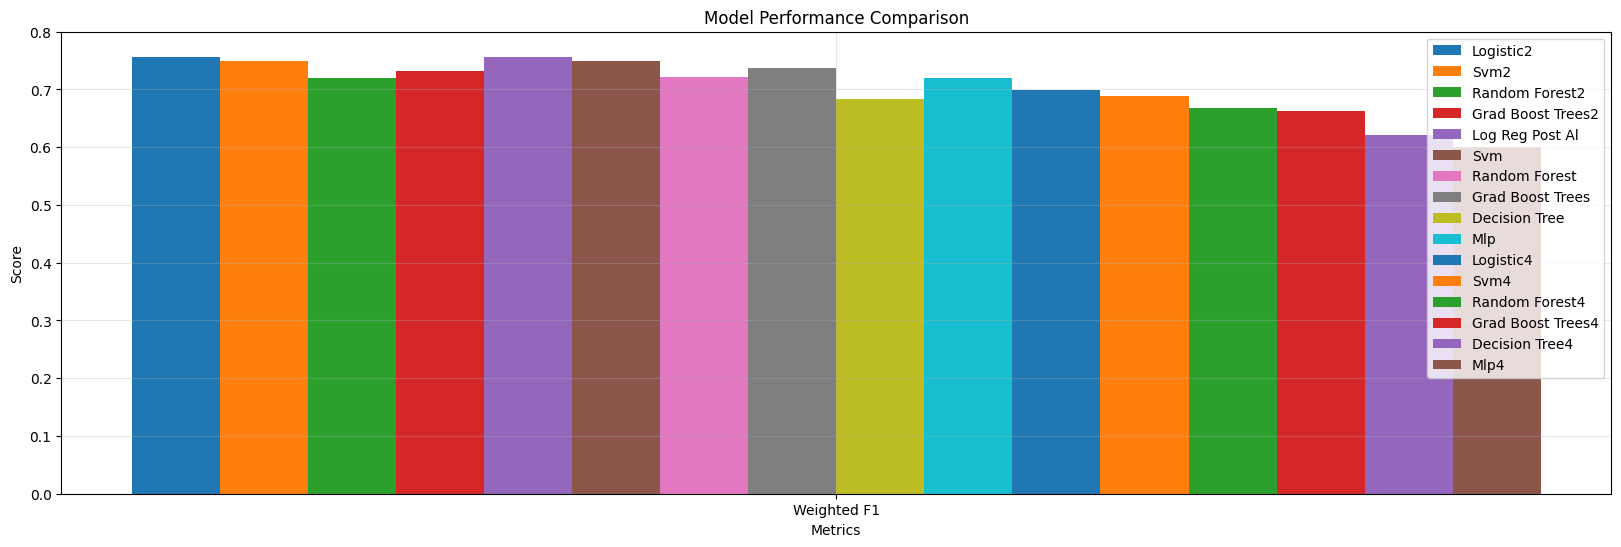

In [ ]:
#@title Plot results
num_models = len(models)
num_metrics = len(metric_names)
bar_width = 0.12

# Create positions for each group of bars
indices = np.arange(num_metrics)

# Create figure and axis with appropriate size
plt.figure(figsize=(20, 6))

# Plot bars for each model
for i, model_name in enumerate(models):
    # Get metrics for this model
    metrics = [model_metrics[model_name][metric] for metric in metric_names]
    # Plot bars with offset
    offset = (i - num_models/2) * bar_width + bar_width/2
    plt.bar(indices + offset, metrics, bar_width,
            label=model_name.replace('_', ' ').title())

# Customize the plot
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(indices, [metric.title() for metric in metric_names])
plt.legend()
plt.grid(True, alpha=0.3)

# Ensure y-axis starts at 0
plt.ylim(0, 0.8)

In [ ]:
#@title Plot results table
model_metrics_df = pd.DataFrame(model_metrics).map(lambda x: round(x, 3))
model_metrics_df

,log reg post AL,svm,random_forest,grad_boost_trees,Decision tree,mlp
accuracy,0.754,0.748,0.797,0.747,0.667,0.780
precision,0.408,0.389,0.588,0.358,0.269,0.348
recall,0.438,0.389,0.049,0.286,0.360,0.079
weighted f1,0.757,0.748,0.722,0.737,0.684,0.721
f1,0.423,0.389,0.091,0.318,0.308,0.129


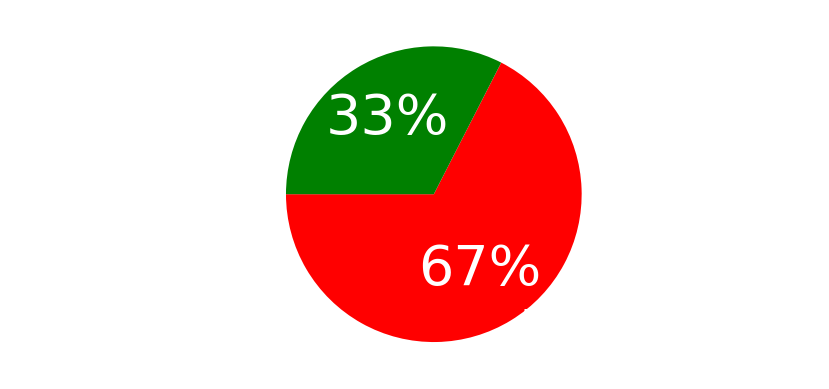

In [ ]:
#@title Labels pie
pie_series = labels_df['label'].value_counts()
palette_color = sns.color_palette('bright')
plt.pie(pie_series, labels=['Bad match', 'Good match'],
        colors=[ 'red','green'], autopct='%.0f%%',
        textprops={'color': 'white', 'size':40},
        startangle=180)
plt.show()

# Labeling analisys

In [ ]:
#@title Create mentor_profile-mentee_profile-label dataframe
mentor_df = sample_df.rename(lambda name: 'mentor_'+name, axis=1)
mentee_df = sample_df.rename(lambda name: 'mentee_'+name, axis=1)

full_labels_df = labels_df.merge(mentor_df, left_on='mentor_id', right_on='mentor_id')
full_labels_df = full_labels_df.merge(mentee_df, left_on='mentee_id', right_on='mentee_id')
full_labels_df = full_labels_df[full_labels_df['label'].notna()]
full_labels_df.head(2)

Text(0.5, 1.0, 'Average label vs mentee followers')

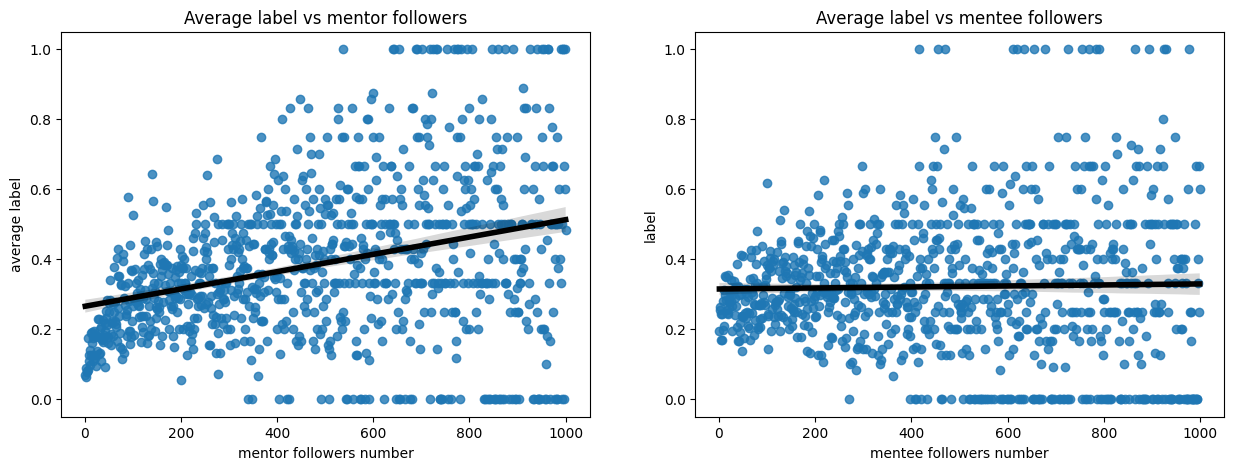

In [ ]:
#@title Plot followers vs label
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

mentor_followers_labels = full_labels_df.groupby('mentor_followers')['label'].mean().to_frame().reset_index()
mentor_followers_labels = mentor_followers_labels[mentor_followers_labels['mentor_followers']<1200]
sns.regplot(data=mentor_followers_labels, x='mentor_followers', y='label',
            line_kws={'color': 'black', 'linewidth': 4}, ax=axs[0])

axs[0].set_xlabel('mentor followers number')
axs[0].set_title('Average label vs mentor followers')
axs[0].set_ylabel('average label')

mentee_followers_labels = full_labels_df.groupby('mentee_followers')['label'].mean().to_frame().reset_index()
mentee_followers_labels = mentee_followers_labels[mentee_followers_labels['mentee_followers']<1000]
sns.regplot(data=mentee_followers_labels, x='mentee_followers', y='label',
            line_kws={'color': 'black', 'linewidth': 4}, ax=axs[1])

axs[1].set_xlabel('mentee followers number')
axs[1].set_title('Average label vs mentee followers')
# axs[1].set_ylabel('average label')

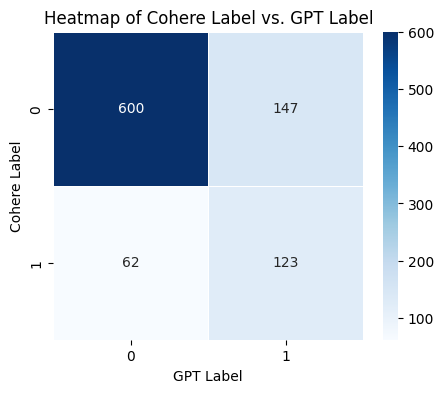

In [ ]:
#@title Confusion matrix of GPT vs Cohere labels
label_pairs = cohere_labels_df.rename(columns={'label':'cohere_label'}, inplace=False)\
                .merge(labels_df, on=['mentor_id', 'mentee_id'])[['cohere_label', 'label']]

conf_matrix = pd.crosstab(label_pairs['cohere_label'], label_pairs['label'])

# Plot heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", linewidths=0.5)

# Labels
plt.xlabel("GPT Label")
plt.ylabel("Cohere Label")
plt.title("Heatmap of Cohere Label vs. GPT Label")

plt.show()